# Counts people depending on the colour of the traffic ligth

# Imports and setup 

In [5]:
###################### Imports #######################


###############
# Ultralytics #
###############

# !pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

######################
# Set Home Directory #
######################

import os
HOME = os.getcwd()
print(HOME)

######################
# Import yolox modek #
######################

# %cd {HOME}
# !git clone https://github.com/ifzhang/ByteTrack.git
# %cd {HOME}/ByteTrack

# # workaround related to https://github.com/roboflow/notebooks/issues/80
# !sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

# !pip3 install -q -r requirements.txt
# !python3 setup.py -q develop
# !pip install -q cython_bbox
# !pip install -q onemetric
# # workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
# !pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

##########################
# Import ByteTrack model #
##########################

from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.10
    track_buffer: int = 50
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False


######################
# Import Supervision #
######################
    
# !pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

from supervision.draw.color import ColorPalette
from supervision.draw.color import Color
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

####################### Setups #######################

######################
# ByteTrack settings #
######################

from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids


##################
# YoloX settings #
##################
from ultralytics import YOLO

MODEL = "yolov8x.pt"


model = YOLO(MODEL)
model.fuse()

supervision.__version__: 0.1.0
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


# Paths and other constants

In [6]:
###################### Paths #######################

SOURCE_VIDEO_PATH = "../Videos/00008-US.mp4"

TARGET_VIDEO_PATH = f"{HOME}/res-01-US_tracked.mp4"

print(f"SOURCE_VIDEO_PATH: {SOURCE_VIDEO_PATH}")
print(f"TARGET_VIDEO_PATH: {TARGET_VIDEO_PATH}")

VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

###################### Class constants #######################

# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - person, car, motorcycle, bus and truck
CLASS_ID = [0, 2, 3, 5, 7]
CLASS_ID_PEOPLE = [0]
CLASS_ID_VEHICLE = [2, 3, 5, 7]
CLASS_ID_TRAFFIC_LIGHT = [9]

SOURCE_VIDEO_PATH: ../Videos/00008-US.mp4
TARGET_VIDEO_PATH: /mnt/Storage/Licenta-main/Licenta/res-01-US.mp4


# Counting algorithm

#### Select areas of interest

In [7]:
import cv2
import numpy as np

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

def select_polygons(image):
    """
    Allows the user to select polygons on an image using mouse clicks until 'Enter' is pressed.
    
    :param image: The image on which polygons will be selected.
    """
    # Initialize global variables
    points = []  # To store the points for the current polygon
    polygons = []  # To store all polygons

    resized_img = cv2.resize(frame, (1000, 800))

    # Calculate scale factors
    originalHeight, originalWidth = frame.shape[:2]
    scaleFactorX = originalWidth / 1000
    scaleFactorY = originalHeight / 800


    def click_event(event, x, y, flags, param):
        nonlocal points, image
        if event == cv2.EVENT_LBUTTONDOWN:  # Left button click
            # scale the points back to the original image size
            x_scaled = int(x * scaleFactorX)
            y_scaled = int(y * scaleFactorY)
            points.append(Point(x_scaled, y_scaled))
            cv2.circle(resized_img, (x, y), 5, (0, 0, 255), -1)  # Draw the dot
            if len(points) > 1:
                cv2.line(resized_img, 
                    (int(points[-2].x // scaleFactorX), int(points[-2].y // scaleFactorY)),
                    (int(points[-1].x // scaleFactorX), int(points[-1].y // scaleFactorY)), 
                    (255, 0, 0), 2)
            cv2.imshow("image", resized_img)  # Show the image with the new dot/line
            
        elif event == cv2.EVENT_RBUTTONDOWN:  # Right button to finish the polygon
            if len(points) > 2:  # Need at least 3 points to form a polygon
                cv2.line(resized_img, 
                    (int(points[-1].x // scaleFactorX), int(points[-1].y // scaleFactorY)),
                    (int(points[0].x // scaleFactorX), int(points[0].y // scaleFactorY)), 
                    (255, 0, 0), 2)
                polygons.append(points.copy())  # Store the completed polygon
                points.clear()  # Reset points for the next polygon
            cv2.imshow("image", resized_img)

    cv2.namedWindow("image")
    cv2.setMouseCallback("image", click_event)
    cv2.imshow("image", resized_img)

    while True:  # Loop to keep the window open until 'Enter' is pressed
        key = cv2.waitKey(0) & 0xFF
        if key == 13:  # ASCII code for Enter key
            break

    cv2.destroyAllWindows()
    return polygons

generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)
polygons = select_polygons(frame)

for i, polygon in enumerate(polygons):
    print(f"Polygon {i+1}: {[f'({p.x}, {p.y})' for p in polygon]}")


Polygon 1: ['(177, 382)', '(866, 331)', '(664, 239)', '(179, 245)']
Polygon 2: ['(2, 394)', '(303, 370)', '(422, 603)', '(19, 630)']
Polygon 3: ['(1226, 484)', '(209, 594)', '(235, 703)', '(1167, 715)', '(1271, 643)', '(1267, 521)']
Polygon 4: ['(733, 342)', '(1155, 576)', '(1274, 492)', '(1251, 360)', '(1203, 308)']


In [8]:
# Method to count vehicles that go from a zone to another

from utils.polygon import Polygon

def count_trajectories(traffic_zones, detections, previous_placements):
    # Define traffic zones trajectories
    # 1-2, 1-3, 1-4, 2-3, 2-4, 3-4, etc
    # Transform traffic zones into polygons
    polygons = [Polygon(polygon) for polygon in traffic_zones]
    nr_zones = len(polygons)
    counts = dict()
    for i in range(nr_zones):
        counts[i] = 0

    # See in which zone the detection is
    # For every detection verify all the polygons and see if it is in one of them
    detection_in_zone = dict()
    for xyxy, confidence, class_id, tracker_id in detections:
        # If there is no tracker_id, we skip the detection
        if tracker_id is None:
            continue

        x1, y1, x2, y2 = xyxy
        # anchors = [
        #     Point(x=x1, y=y1),
        #     Point(x=x1, y=y2),
        #     Point(x=x2, y=y1),
        #     Point(x=x2, y=y2),
        # ]

        # Workaround for the fact that the bboxes are too big

        '''
            Introduce a padding so the bbox will be the one in the interior of the original one, like so:
            |-----------------------|
            |  \                  / |
            |   \---------------/   |
            |   |Bbox w padding |   |
            |   /---------------\   |
            | /                  \  |
            |-----------------------|
        
        '''
        # Preduce the box by 40% of its original size
        percentange = 0.3
        anchors = [
            Point(x=x1 + (x2 - x1) * percentange, y=y1 + (y2 - y1) * percentange),
            Point(x=x1 + (x2 - x1) * percentange, y=y2 - (y2 - y1) * percentange),
            Point(x=x2 - (x2 - x1) * percentange, y=y1 + (y2 - y1) * percentange),
            Point(x=x2 - (x2 - x1) * percentange, y=y2 - (y2 - y1) * percentange),
        ]

        for i, polygon in enumerate(polygons):
            ok = True
            # For every side of the polygon chech if the 4 points are inside the polygon
            for anchor in anchors:
                if not polygon.is_in(anchor):
                    ok = False
                    break
            if ok:
                # If the detection is in the polygon, increment the counter
                detection_in_zone[tracker_id] = i


        # Check if the detection changed the zone
        # PS: We ignore if the detection is in the same zone or the detection system didn't assign it to a zone
        if tracker_id in previous_placements:
            if tracker_id in detection_in_zone and detection_in_zone[tracker_id] != previous_placements.get(tracker_id, -1) \
            and (detection_in_zone[tracker_id] is not None or i >= 0):
                if (previous_placements[tracker_id], detection_in_zone[tracker_id]) not in counts:
                    counts[(previous_placements[tracker_id], detection_in_zone[tracker_id])] = 1
                elif previous_placements.get(tracker_id, -1) >= 0:
                    counts[(previous_placements[tracker_id], detection_in_zone[tracker_id])] += 1


        

    return counts, detection_in_zone, counts

### Predict on whole video

In [26]:
from cProfile import label
from tabnanny import verbose
from tqdm.notebook import tqdm
import cv2
from numpy import argmax
import pandas as pd
from datetime import timedelta
from collections import defaultdict

def annotate_with_counts(frame, time, counts, font_scale=1, thickness=2):
    for i, transitions in enumerate(counts.keys()):
        if counts[transitions] > 0:
            cv2.putText(frame, f"{transitions[0]+1} -> {transitions[1]+1}: {counts[transitions]}", (10, i * 30), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), thickness)

    


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# video_info = VideoInfo.from_video_path(AUX_VIDEO_PATH)
# # create frame generator
# generator = get_video_frames_generator(AUX_VIDEO_PATH)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.5)


# open target video file
detection_position = dict()
transition_counts = dict()
track_history = defaultdict(lambda: [])
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame_nr, frame in enumerate(tqdm(generator, total=video_info.total_frames), start=1):        # model prediction on single frame and conversion to supervision Detections
        # print(f"frame_nr: {frame_nr}")
        results = model.track(frame, verbose=False, persist=True)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        detections_people = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        detections_vehicles = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        detections_traffic_light = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask_people = np.array([class_id in CLASS_ID_PEOPLE for class_id in detections.class_id], dtype=bool)
        mask_vehicle = np.array([class_id in CLASS_ID_VEHICLE for class_id in detections.class_id], dtype=bool)
        mask_traffic_light= np.array([class_id in CLASS_ID_TRAFFIC_LIGHT for class_id in detections.class_id], dtype=bool)
        detections_people.filter(mask=mask_people, inplace=True)
        detections_vehicles.filter(mask=mask_vehicle, inplace=True)
        detections_traffic_light.filter(mask=mask_traffic_light, inplace=True)
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks_people = byte_tracker.update(
            output_results=detections2boxes(detections=detections_people),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracks_vehicles = byte_tracker.update(
            output_results=detections2boxes(detections=detections_vehicles),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        tracker_id_people = match_detections_with_tracks(detections=detections_people, tracks=tracks_people)
        tracker_id_vehicles = match_detections_with_tracks(detections=detections_vehicles, tracks=tracks_vehicles)
        detections.tracker_id = np.array(tracker_id)
        detections_people.tracker_id = np.array(tracker_id_people)
        detections_vehicles.tracker_id = np.array(tracker_id_vehicles)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        mask_people = np.array([tracker_id is not None for tracker_id in detections_people.tracker_id], dtype=bool)
        mask_vehicles = np.array([tracker_id is not None for tracker_id in detections_vehicles.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        detections_people.filter(mask=mask_people, inplace=True)
        detections_vehicles.filter(mask=mask_vehicles, inplace=True)

        # Get traffic zones count
        traffic_zones, detection_in_zone, counts = count_trajectories(polygons, detections, detection_position)
        for _, confidence, class_id, tracker_id in detections:
            if tracker_id is not None and detection_in_zone.get(tracker_id, -1) >= 0:
                detection_position[tracker_id] = detection_in_zone.get(tracker_id, -1)
        for count in counts.keys():
            if count not in transition_counts.keys():
                transition_counts[count] = 0
            transition_counts[count] += counts[count]
        labels = [
            f"#{tracker_id} {detection_in_zone.get(tracker_id, -1) + 1}" if tracker_id is not None else f"#{tracker_id}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        # Write in the center of the polygon the number of the polygon
        for i, polygon in enumerate(polygons):
            x = 0
            y = 0
            for point in polygon:
                x += point.x
                y += point.y
            x = int(x / len(polygon))
            y = int(y / len(polygon))
            cv2.putText(frame, f"{i+1}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        # Annotate with counts
        annotate_with_counts(frame, 0, transition_counts)
        # Draw the polygons
        for i, polygon in enumerate(polygons):
            color = (255, 0, 0)
            if i == 0:
                color = (0, 255, 0)
            for j in range(len(polygon)):
                cv2.line(frame, (polygon[j].x, polygon[j].y), (polygon[(j+1) % len(polygon)].x, polygon[(j+1) % len(polygon)].y), color, 2)

        # Plot the tracks

        for box, track_id in zip(detections.xyxy, detections.tracker_id):
            x1, y1, x2, y2 = box
            track = track_history[track_id] # this is getting the memory location of the list so it will be updated
            track.append((float(x1 + x2) / 2, float(y1 + y2) / 2))
            # if len(track) > 30:
            #     track.pop(0)
            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(frame, [points], isClosed=False, color=(230, 230, 230), thickness=10)

        sink.write_frame(frame)

  0%|          | 0/9406 [00:00<?, ?it/s]


0: 384x640 2 cars, 1 truck, 4 traffic lights, 27.6ms
Speed: 14.3ms preprocess, 27.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 2 trucks, 4 traffic lights, 25.5ms
Speed: 0.9ms preprocess, 25.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 2 trucks, 4 traffic lights, 25.8ms
Speed: 1.4ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 2 trucks, 4 traffic lights, 25.6ms
Speed: 1.0ms preprocess, 25.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 2 trucks, 4 traffic lights, 26.7ms
Speed: 0.9ms preprocess, 26.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 2 trucks, 4 traffic lights, 26.0ms
Speed: 0.7ms preprocess, 26.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 2 trucks, 4 traffic lights, 25.6ms
Speed: 1.1ms preprocess, 25.6ms i

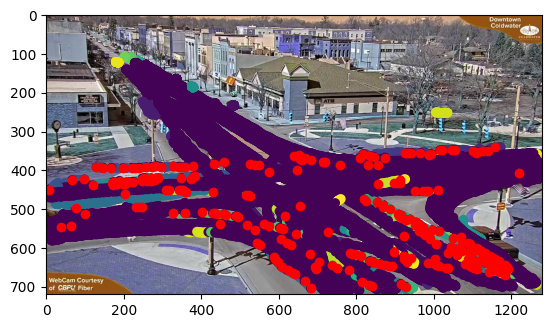

In [37]:
from sklearn.cluster import DBSCAN
import numpy as np

data = []
for track in track_history.values():
    data.extend(track)

data = np.array(data)

db = DBSCAN(eps=5, min_samples=2).fit(data)

labels = db.labels_

import matplotlib.pyplot as plt

generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
plt.scatter(data[:, 0], data[:, 1], c=labels)
frame = next(iter(generator))
plt.imshow(frame)

# Find anomalies
anomalies = data[db.labels_ == -1]
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='red')
frame = next(iter(generator))
plt.imshow(frame)

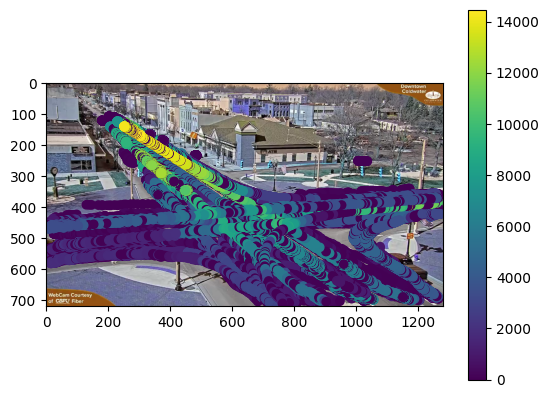

In [33]:
# !pip install hdbscan
from hdbscan import HDBSCAN
import numpy as np

data = []
for track in track_history.values():
    data.extend(track)

data = np.array(data)

# Create a HDBSCAN instance and fit the data
# min_cluster_size is the minimum number of samples in a neighborhood for a point to be considered as a core point
db = HDBSCAN(min_cluster_size=2).fit(data)

labels = db.labels_

import matplotlib.pyplot as plt

generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
plt.scatter(data[:, 0], data[:, 1], c=labels)
frame = next(iter(generator))
# Show the meaning of the colors
plt.colorbar()
plt.imshow(frame)

